# Task Relatedness

The goal of this notebook is to get a handle on which tasks are most related to each other. To this end, we explore two metric:

- Conditional entropy
- Pairwise mutual information

The intuition for conditional entropy is it is a measure for how much information knowing the label of the first task gives you about the label of the second task. This measure would be most useful if we were using the output of a single task classifier as a feature to predict another task.

Pairwise mutual information gets at the same idea: pairwise mutual information will be high when the two tasks are related and low otherwise. This measure has implications for determining which tasks will most likely work in a multitask setting; tasks with high mutual information will not have to compete for the feature space - they will be complementary. However, when it comes to generating features for a new task, it is probably the case that learning features for two tasks which have low PMI will result in more diverse features.

In [65]:
%store -r composite_labels

df = composite_labels

### Conditional Entropy and Pointwise Mutual Information Functions

In [190]:
from scipy import stats

def compute_entropy(df, t1, t2, weighted=False):
    """Given task t1, compute the entropy for each class in t2"""

    df1 = pd.DataFrame(0, index=df[t1].cat.categories.tolist(), columns=df[t2].cat.categories.tolist())

    # Compute co-occurrence
    for v1, v2 in zip(df[t1], df[t2]):
        if pd.isnull(v1) or pd.isnull(v2):
            continue

        df1.ix[v1, v2] += 1    

    t1_sizes = df1.sum(axis=1)
    
    df1 = df1 / df1.sum(axis=0) # normalize by class counts
    df1 = (df1.T / df1.sum(axis=1)).T # normalize rows

    entropies = stats.entropy(df1.T)
    
    entropy_weights = t1_sizes / t1_sizes.sum() if weighted else np.full(shape=entropies.shape, fill_value=1./len(entropies))

    return np.sum(entropy_weights * entropies), df1

def mutual_info_scores(task):
    for col in df.columns:
        if col == task:
            continue
            
        yield mutual_info_score(df[task], df[col]), col

for task in df.columns:
    print '***', task, '***'
    
    for score, t in sorted(mutual_info_scores(task), reverse=True):
        print t, score
    
    print

def mutual_infos_generator():
    for i, task in enumerate(df.columns):
        for j in range(i+1, len(df.columns)):
            score = mutual_info_score(df[task], df[df.columns[j]])

            yield score, task, df.columns[j]

### Ranked Mutual Information Scores

In [191]:
from IPython.display import display

for score, t1, t2 in sorted(mutual_infos_generator(), reverse=True):
    print '{} <-> {}: {}'.format(t1, t2, score)
    
    compute_entropy(df, t1, t2)
    compute_entropy(df, t2, t1)

allocation <-> intervention_model: 0.403411616604
allocation <-> masking: 0.198669113985
intervention_model <-> masking: 0.153505935295
endpoint_classification <-> phase: 0.10776848601
primary_purpose <-> healthy_volunteers: 0.0681010430658
intervention_model <-> phase: 0.0629480029522
masking <-> phase: 0.0548764018604
primary_purpose <-> phase: 0.0530305638964
allocation <-> phase: 0.0499529946636
endpoint_classification <-> primary_purpose: 0.04368782284
endpoint_classification <-> intervention_model: 0.0337625315923
healthy_volunteers <-> phase: 0.023914094715
intervention_model <-> primary_purpose: 0.0228390391972
allocation <-> endpoint_classification: 0.020186921478
endpoint_classification <-> masking: 0.0198490824996
allocation <-> primary_purpose: 0.0166093881682
endpoint_classification <-> healthy_volunteers: 0.0158485002519
intervention_model <-> healthy_volunteers: 0.0110607049026
masking <-> primary_purpose: 0.00954596477306
gender <-> healthy_volunteers: 0.00749447886806


### Mutual Information DataFrames

In [193]:
from IPython.display import display

for score, t1, t2 in sorted(mutual_infos_generator(), reverse=True):
    
    e1, df1 = compute_entropy(df, t1, t2)
    print '{} -> {}: {} ({})'.format(t1, t2, e1, score)
    display(df1)
    
    e2, df2 = compute_entropy(df, t2, t1)
    print '{} -> {}: {} ({})'.format(t2, t1, e2, score)
    display(df2)

allocation -> intervention_model: 0.638340521257 (0.403411616604)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
Non-Randomized,0.034598,0.060695,0.904707
Randomized,0.470613,0.458621,0.070765


intervention_model -> allocation: 0.396064535858 (0.403411616604)


,Non-Randomized,Randomized
Crossover Assignment,0.180913,0.819087
Parallel Assignment,0.284488,0.715512
Single Group Assignment,0.974625,0.025375


allocation -> masking: 0.691858180289 (0.198669113985)


,Double Blind,Open Label,Single Blind
Non-Randomized,0.023187,0.929650,0.047163
Randomized,0.373481,0.256141,0.370378


masking -> allocation: 0.359015411128 (0.198669113985)


,Non-Randomized,Randomized
Double Blind,0.050758,0.949242
Open Label,0.757635,0.242365
Single Blind,0.098834,0.901166


intervention_model -> masking: 0.903566933577 (0.153505935295)


,Double Blind,Open Label,Single Blind
Crossover Assignment,0.477046,0.237458,0.285496
Parallel Assignment,0.401737,0.218335,0.379928
Single Group Assignment,0.027490,0.792323,0.180187


masking -> intervention_model: 0.927658277124 (0.153505935295)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
Double Blind,0.505659,0.470228,0.024113
Open Label,0.209356,0.212564,0.578080
Single Blind,0.334248,0.491179,0.174574


endpoint_classification -> phase: 1.55566671682 (0.10776848601)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Efficacy Study,0.344862,0.092148,0.082375,0.124637,0.121635,0.234343
Safety Study,0.031124,0.585934,0.159554,0.099201,0.040741,0.083445
Safety/Efficacy Study,0.085980,0.119816,0.220665,0.207799,0.222660,0.143079


phase -> endpoint_classification: 0.913293319184 (0.10776848601)


,Efficacy Study,Safety Study,Safety/Efficacy Study
N/A,0.699043,0.130789,0.170169
Phase 1,0.064719,0.853116,0.082165
Phase 1/Phase 2,0.131046,0.526199,0.342755
Phase 2,0.233761,0.385706,0.380532
Phase 3,0.287216,0.199433,0.513350
Phase 4,0.428390,0.316230,0.255380


primary_purpose -> healthy_volunteers: 0.536953806708 (0.0681010430658)


,Accepts Healthy Volunteers,No
Prevention,0.854397,0.145603
Treatment,0.369898,0.630102


healthy_volunteers -> primary_purpose: 0.543317564404 (0.0681010430658)


,Prevention,Treatment
Accepts Healthy Volunteers,0.834331,0.165669
No,0.335029,0.664971


intervention_model -> phase: 1.6222780398 (0.0629480029522)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Crossover Assignment,0.165451,0.514942,0.053181,0.096369,0.064891,0.105167
Parallel Assignment,0.189621,0.104915,0.119650,0.149240,0.234208,0.202365
Single Group Assignment,0.119772,0.166440,0.305203,0.228357,0.064656,0.115573


phase -> intervention_model: 0.974297385002 (0.0629480029522)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
N/A,0.422034,0.315309,0.262657
Phase 1,0.708870,0.094150,0.196979
Phase 1/Phase 2,0.135125,0.198184,0.666691
Phase 2,0.247113,0.249470,0.503417
Phase 3,0.237561,0.558943,0.203496
Phase 4,0.312581,0.392097,0.295322


masking -> phase: 1.71456570179 (0.0548764018604)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Double Blind,0.111101,0.145642,0.101689,0.166430,0.274261,0.200877
Open Label,0.168619,0.185198,0.219484,0.178773,0.102202,0.145725
Single Blind,0.387527,0.143438,0.121610,0.094994,0.103256,0.149175


phase -> masking: 1.03515636946 (0.0548764018604)


,Double Blind,Open Label,Single Blind
N/A,0.146678,0.277756,0.575565
Phase 1,0.270672,0.429438,0.299891
Phase 1/Phase 2,0.198476,0.534500,0.267024
Phase 2,0.335307,0.449389,0.215304
Phase 3,0.529524,0.246201,0.224276
Phase 4,0.364888,0.330273,0.304839


primary_purpose -> phase: 1.77916583724 (0.0530305638964)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Prevention,0.169583,0.232694,0.108134,0.152432,0.177061,0.160096
Treatment,0.166172,0.155463,0.176598,0.169082,0.164903,0.167782


phase -> primary_purpose: 0.684609263793 (0.0530305638964)


,Prevention,Treatment
N/A,0.506762,0.493238
Phase 1,0.601098,0.398902
Phase 1/Phase 2,0.381360,0.618640
Phase 2,0.475784,0.524216
Phase 3,0.519455,0.480545
Phase 4,0.489961,0.510039


allocation -> phase: 1.72858206639 (0.0499529946636)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Non-Randomized,0.118402,0.177858,0.324566,0.206462,0.069869,0.102843
Randomized,0.176229,0.164449,0.135382,0.158782,0.185845,0.179312


phase -> allocation: 0.648856265343 (0.0499529946636)


,Non-Randomized,Randomized
N/A,0.475323,0.524677
Phase 1,0.593220,0.406780
Phase 1/Phase 2,0.763741,0.236259
Phase 2,0.636799,0.363201
Phase 3,0.336400,0.663600
Phase 4,0.436098,0.563902


endpoint_classification -> primary_purpose: 0.675316324298 (0.04368782284)


,Prevention,Treatment
Efficacy Study,0.486417,0.513583
Safety Study,0.660934,0.339066
Safety/Efficacy Study,0.486035,0.513965


primary_purpose -> endpoint_classification: 1.07687325598 (0.04368782284)


,Efficacy Study,Safety Study,Safety/Efficacy Study
Prevention,0.263879,0.472590,0.263531
Treatment,0.348385,0.303154,0.348460


endpoint_classification -> intervention_model: 1.07069672864 (0.0337625315923)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
Efficacy Study,0.404706,0.386436,0.208857
Safety Study,0.390139,0.211919,0.397942
Safety/Efficacy Study,0.284674,0.318206,0.397120


intervention_model -> endpoint_classification: 1.06698038469 (0.0337625315923)


,Efficacy Study,Safety Study,Safety/Efficacy Study
Crossover Assignment,0.334701,0.421365,0.243934
Parallel Assignment,0.389205,0.278736,0.332059
Single Group Assignment,0.183207,0.455863,0.360929


healthy_volunteers -> phase: 1.73119113991 (0.023914094715)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Accepts Healthy Volunteers,0.218636,0.323224,0.105555,0.101480,0.096270,0.154834
No,0.151742,0.121705,0.184217,0.185387,0.186884,0.170065


phase -> healthy_volunteers: 0.651740309653 (0.023914094715)


,Accepts Healthy Volunteers,No
N/A,0.637147,0.362853
Phase 1,0.763961,0.236039
Phase 1/Phase 2,0.411176,0.588824
Phase 2,0.400157,0.599843
Phase 3,0.385669,0.614331
Phase 4,0.525964,0.474036


intervention_model -> primary_purpose: 0.61047713794 (0.0228390391972)


,Prevention,Treatment
Crossover Assignment,0.283983,0.716017
Parallel Assignment,0.573091,0.426909
Single Group Assignment,0.241089,0.758911


primary_purpose -> intervention_model: 1.01129507257 (0.0228390391972)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
Prevention,0.210229,0.619263,0.170508
Treatment,0.346875,0.301881,0.351244


allocation -> endpoint_classification: 1.04272478137 (0.020186921478)


,Efficacy Study,Safety Study,Safety/Efficacy Study
Non-Randomized,0.138818,0.496306,0.364876
Randomized,0.366496,0.305549,0.327956


endpoint_classification -> allocation: 0.648184198368 (0.020186921478)


,Non-Randomized,Randomized
Efficacy Study,0.311471,0.688529
Safety Study,0.659855,0.340145
Safety/Efficacy Study,0.570587,0.429413


endpoint_classification -> masking: 1.05839052943 (0.0198490824996)


,Double Blind,Open Label,Single Blind
Efficacy Study,0.275979,0.267365,0.456656
Safety Study,0.427955,0.407446,0.164598
Safety/Efficacy Study,0.369314,0.377998,0.252689


masking -> endpoint_classification: 1.048497258 (0.0198490824996)


,Efficacy Study,Safety Study,Safety/Efficacy Study
Double Blind,0.312808,0.354377,0.332815
Open Label,0.308889,0.343901,0.347210
Single Blind,0.587103,0.154602,0.258295


allocation -> primary_purpose: 0.643933462015 (0.0166093881682)


,Prevention,Treatment
Non-Randomized,0.283055,0.716945
Randomized,0.523401,0.476599


primary_purpose -> allocation: 0.646210000532 (0.0166093881682)


,Non-Randomized,Randomized
Prevention,0.288867,0.711133
Treatment,0.530496,0.469504


endpoint_classification -> healthy_volunteers: 0.6784051986 (0.0158485002519)


,Accepts Healthy Volunteers,No
Efficacy Study,0.570376,0.429624
Safety Study,0.611774,0.388226
Safety/Efficacy Study,0.432693,0.567307


healthy_volunteers -> endpoint_classification: 1.0836251351 (0.0158485002519)


,Efficacy Study,Safety Study,Safety/Efficacy Study
Accepts Healthy Volunteers,0.360564,0.411439,0.227997
No,0.326580,0.313963,0.359457


intervention_model -> healthy_volunteers: 0.651194660717 (0.0110607049026)


,Accepts Healthy Volunteers,No
Crossover Assignment,0.710027,0.289973
Parallel Assignment,0.508894,0.491106
Single Group Assignment,0.369086,0.630914


healthy_volunteers -> intervention_model: 1.04520458742 (0.0110607049026)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
Accepts Healthy Volunteers,0.533354,0.288176,0.178470
No,0.271936,0.347195,0.380869


masking -> primary_purpose: 0.677935045212 (0.00954596477306)


,Prevention,Treatment
Double Blind,0.534212,0.465788
Open Label,0.433118,0.566882
Single Blind,0.630242,0.369758


primary_purpose -> masking: 1.07978855589 (0.00954596477306)


,Double Blind,Open Label,Single Blind
Prevention,0.324444,0.228433,0.447123
Treatment,0.335098,0.354163,0.310739


gender -> healthy_volunteers: 0.659077760556 (0.00749447886806)


,Accepts Healthy Volunteers,No
Both,0.467848,0.532152
Female,0.682094,0.317906
Male,0.626341,0.373659


healthy_volunteers -> gender: 1.0788554006 (0.00749447886806)


,Both,Female,Male
Accepts Healthy Volunteers,0.217964,0.423904,0.358131
No,0.376127,0.299738,0.324135


allocation -> healthy_volunteers: 0.692946255313 (0.00672631631148)


,Accepts Healthy Volunteers,No
Non-Randomized,0.485978,0.514022
Randomized,0.502069,0.497931


healthy_volunteers -> allocation: 0.692974574495 (0.00672631631148)


,Non-Randomized,Randomized
Accepts Healthy Volunteers,0.487311,0.512689
No,0.503404,0.496596


masking -> healthy_volunteers: 0.673064643173 (0.00577983769826)


,Accepts Healthy Volunteers,No
Double Blind,0.492868,0.507132
Open Label,0.464230,0.535770
Single Blind,0.668034,0.331966


healthy_volunteers -> masking: 1.07530563814 (0.00577983769826)


,Double Blind,Open Label,Single Blind
Accepts Healthy Volunteers,0.27564,0.250974,0.473386
No,0.35079,0.358254,0.290956


gender -> phase: 1.7648018747 (0.0043013335127)


,N/A,Phase 1,Phase 1/Phase 2,Phase 2,Phase 3,Phase 4
Both,0.168581,0.168934,0.157392,0.162104,0.171685,0.171304
Female,0.160144,0.132913,0.244156,0.172787,0.126636,0.163363
Male,0.141264,0.198895,0.179870,0.249782,0.154970,0.075219


phase -> gender: 1.07863253389 (0.0043013335127)


,Both,Female,Male
N/A,0.350996,0.358111,0.290894
Phase 1,0.332287,0.280786,0.386927
Phase 1/Phase 2,0.263410,0.438863,0.297727
Phase 2,0.272570,0.312039,0.415390
Phase 3,0.372448,0.295054,0.332498
Phase 4,0.406750,0.416607,0.176643


endpoint_classification -> gender: 1.06836825988 (0.00390385984611)


,Both,Female,Male
Efficacy Study,0.319073,0.329899,0.351028
Safety Study,0.502616,0.165020,0.332364
Safety/Efficacy Study,0.330189,0.347770,0.322041


gender -> endpoint_classification: 1.0625279605 (0.00390385984611)


,Efficacy Study,Safety Study,Safety/Efficacy Study
Both,0.324357,0.350178,0.325465
Female,0.422835,0.144959,0.432206
Male,0.393935,0.255633,0.350432


masking -> gender: 1.07969527909 (0.00302079323969)


,Both,Female,Male
Double Blind,0.365133,0.272041,0.362827
Open Label,0.298483,0.370605,0.330912
Single Blind,0.408023,0.392325,0.199651


gender -> masking: 1.07638399846 (0.00302079323969)


,Double Blind,Open Label,Single Blind
Both,0.338537,0.322409,0.339053
Female,0.257756,0.409089,0.333156
Male,0.391280,0.415750,0.192969


intervention_model -> gender: 1.07595720465 (0.00192643015147)


,Both,Female,Male
Crossover Assignment,0.373231,0.182446,0.444323
Parallel Assignment,0.336632,0.326886,0.336482
Single Group Assignment,0.313562,0.392300,0.294138


gender -> intervention_model: 1.07643212302 (0.00192643015147)


,Crossover Assignment,Parallel Assignment,Single Group Assignment
Both,0.343647,0.331766,0.324586
Female,0.187432,0.359459,0.453109
Male,0.391411,0.317277,0.291312


allocation -> gender: 1.09732889355 (0.00173377270365)


,Both,Female,Male
Non-Randomized,0.320773,0.312623,0.366604
Randomized,0.335296,0.336570,0.328134


gender -> allocation: 0.692155953829 (0.00173377270365)


,Non-Randomized,Randomized
Both,0.498856,0.501144
Female,0.491474,0.508526
Male,0.537570,0.462430


primary_purpose -> gender: 1.0855765307 (0.00136481369669)


,Both,Female,Male
Prevention,0.306638,0.436637,0.256724
Treatment,0.338109,0.314851,0.347040


gender -> primary_purpose: 0.684539865697 (0.00136481369669)


,Prevention,Treatment
Both,0.490916,0.509084
Female,0.595889,0.404111
Male,0.440268,0.559732


### Visualize PMI as Heat Maps

Note the heat maps are very salient starting out and progressively get more diffuse.

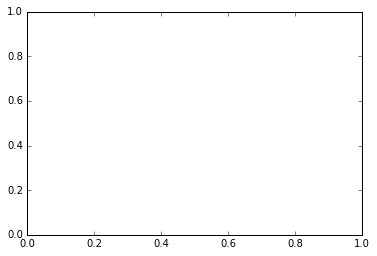

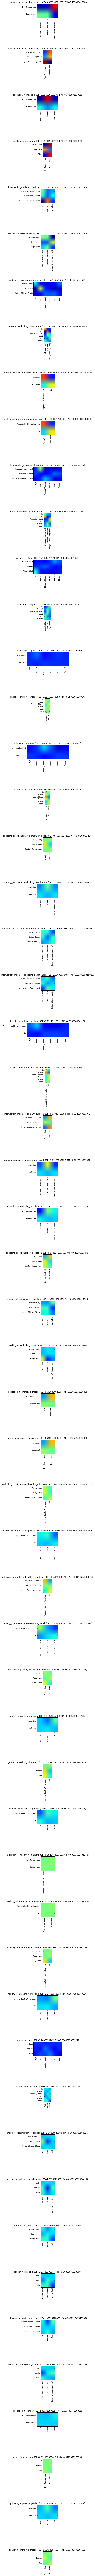

In [196]:
from IPython.display import display

axes = plt.gca()
fig = plt.figure(figsize=[10,300])

i = 0
for score, t1, t2 in sorted(mutual_infos_generator(), reverse=True):
    
    e1, df1 = compute_entropy(df, t1, t2)
    axes = fig.add_subplot(60, 1, i+1)
    axes.imshow(df1, vmin=0, vmax=1)
    plt.title('{} -> {}: (CE={}, PMI={})'.format(t1, t2, e1, score))
    x_marks, y_marks = np.arange(len(df1.columns)), np.arange(len(df1.index))
    plt.xticks(x_marks, df1.columns, rotation=90)
    plt.yticks(y_marks, df1.index)
    
    e2, df2 = compute_entropy(df, t2, t1)
    axes = fig.add_subplot(60, 1, i+2)
    axes.imshow(df2, vmin=0, vmax=1)
    plt.title('{} -> {}: (CE={}, PMI={})'.format(t2, t1, e2, score))
    x_marks, y_marks = np.arange(len(df2.columns)), np.arange(len(df2.index))
    plt.xticks(x_marks, df2.columns, rotation=90)
    plt.yticks(y_marks, df2.index)
    
    i += 2
    
fig.subplots_adjust(wspace=.35, hspace=2.3)

### Compute Conditional Entropies for Each Class

I generally found PMI to give a more intuitive ordering of task-relatedness.

In [71]:
def entropies_generator(task, weighted):
    for column in df.columns:
        if column == task:
            continue
            
        yield compute_entropy(df, task, column, weighted), column
        

for column in df.columns:
    entropies = list(entropies_generator(column, weighted=True))
    
    print '***', column, '***'
    
    for entropy, task in sorted(entropies):
        print task, entropy
    
    print

*** allocation ***
primary_purpose 0.679966981201
healthy_volunteers 0.693088348024
intervention_model 0.830304505778
masking 0.981953919429
endpoint_classification 1.08252470153
gender 1.09823115277
phase 1.77174542172

*** endpoint_classification ***
allocation 0.656865220443
healthy_volunteers 0.682791561352
primary_purpose 0.68956138281
masking 1.07357151501
intervention_model 1.0772809675
gender 1.0926998622
phase 1.67811321621

*** intervention_model ***
allocation 0.539335365653
primary_purpose 0.645288731089
healthy_volunteers 0.677495373237
masking 0.948636819063
endpoint_classification 1.07642555455
gender 1.09198140747
phase 1.70976688802

*** masking ***
allocation 0.351634400098
primary_purpose 0.68495544801
healthy_volunteers 0.686521927565
intervention_model 0.900216550599
endpoint_classification 1.08403472299
gender 1.08892782396
phase 1.74140432001

*** primary_purpose ***
healthy_volunteers 0.62375374769
allocation 0.676309775991
intervention_model 1.07186050405
endpo